In [1]:
import pandas as pd

from preprocess import clean_dataframe,get_train_test_val,bin_age
# https://scikit-learn.org/stable/modules/svm.html
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

raw_data = pd.read_csv('Murder_Data.zip', index_col=0, compression='zip')
cleaned_data = clean_dataframe(raw_data)
#get a stratisfied subset to test the algorithms on
#train,test = split_stratify(...)
#cleaned_data, _ = split_stratify(cleaned_data,['OffSex', 'OffRace', 'OffEthnic'],0.20,0.01)
#cleaned_data.shape

C:\Users\PedroAntonio\Anaconda3\envs\proj\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
cleaned_data["OffAge"] = bin_age(cleaned_data, "OffAge")
cleaned_data['VicAge'].replace(to_replace='Unknown', value = 999, inplace = True)
cleaned_data.drop(['State','County', 'Area',"FileMonth","FileDay","FileYear","Agency","Agentype","Source","Solved","Year","Month","ActionType"],inplace=True,axis=1)
cleaned_data_dummies = pd.get_dummies(cleaned_data,columns=['VicSex', 'VicRace', 'VicEthnic', 'Weapon', 'Subcircum', 'Circumstance', 'Homicide'])

cleaned_data,trainingset,testset,valset = get_train_test_val(cleaned_data_dummies,['OffAge', 'OffSex', 'OffRace', 'OffEthnic'])


#input_features = ['County', 'State', 'Area', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic', 'VicCount', 'Weapon', 'Subcircum', 'Circumstance', 'Homicide']
output_features = ['OffAge', 'OffSex', 'OffRace', 'OffEthnic', 'OffCount','Relationship']

#X = cleaned_data[input_features]
#Y = cleaned_data[output_features]

#X['VicAge'].replace(to_replace='Unknown', value = -1, inplace = True)
#Y['OffAge'].replace(to_replace='Unknown', value = -1, inplace = True)

x_test,y_test = testset.drop(output_features,axis=1,inplace=False),testset[output_features]
x_val,y_val = valset.drop(output_features,axis=1,inplace=False),valset[output_features]
x_train,y_train = trainingset.drop(output_features,axis=1,inplace=False),trainingset[output_features]

#X = pd.get_dummies(X,columns=['County', 'State', 'Area', 'VicSex', 'VicRace', 'VicEthnic', 'Weapon', 'Subcircum', 'Circumstance', 'Homicide'])

#x_train, x_rest, y_train, y_rest = train_test_split(X, Y, test_size=0.20, random_state=20)
#x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, test_size=0.50, random_state=20)

#y_val_age = pd.get_dummies(val_y['OffAge'],columns=['OffAge'])
#val_y.insert(18,"OffRace_Native Hawaiian or Pacific Islander",0)
#val_y.insert(28,"OffCount_6",0)
#y_test_age = pd.get_dummies(test_y['OffAge'],columns=['OffAge'])
#test_y.insert(18,"OffRace_Native Hawaiian or Pacific Islander",0)
#y_train_age = pd.get_dummies(training_y['OffAge'],columns=['OffAge'])

#y_val_sex = pd.get_dummies(val_y['OffSex'],columns=['OffSex'])
#y_test_sex = pd.get_dummies(test_y['OffSex'],columns=['OffSex'])
#y_train_sex = pd.get_dummies(training_y['OffSex'],columns=['OffSex'])

#y_val_race = pd.get_dummies(val_y['OffRace'],columns=['OffRace'])
#y_val_race.insert(3,"Native Hawaiian or Pacific Islander",0)
#y_test_race = pd.get_dummies(test_y['OffRace'],columns=['OffRace'])
#y_test_race.insert(3,"Native Hawaiian or Pacific Islander",0)
#y_train_race = pd.get_dummies(training_y['OffRace'],columns=['OffRace'])

#y_val_ethnic = pd.get_dummies(val_y['OffEthnic'],columns=['OffEthnic'])
#y_test_y_ethnic = pd.get_dummies(test_y['OffEthnic'],columns=['OffEthnic'])
#y_train_ethnic = pd.get_dummies(training_y['OffEthnic'],columns=['OffEthnic'])

#y_val_count = pd.get_dummies(val_y['OffCount'],columns=['OffCount'])
#y_val_count.insert(6,'6',0)
#val_y_count.insert(7,"7",0)
#val_y_count.insert(11,11,0)
#y_test_count = pd.get_dummies(test_y['OffCount'],columns=['OffCount'])
#test_y_count.insert(11,11,0)
#y_train_count = pd.get_dummies(training_y['OffCount'],columns=['OffCount'])


#y_val_relation = pd.get_dummies(val_y['Relationship'],columns=['Relationship'])
#y_test_relation = pd.get_dummies(test_y['Relationship'],columns=['Relationship'])
#y_train_relation = pd.get_dummies(training_y['Relationship'],columns=['Relationship'])

#print(y_train_age.head())
#print(y_train_sex.head())
#print(y_train_race.head())
#print(y_train_ethnic.head())
#print(y_train_count.head())
#print(y_train_relation.head())

0.8871733237417646


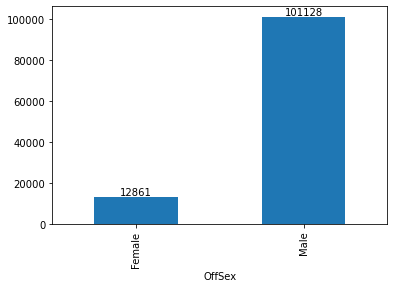

In [3]:
df=cleaned_data.groupby(["OffSex"]).size()
ax = df.plot(kind='bar')
ax.bar_label(ax.containers[0])
print(len(cleaned_data[cleaned_data["OffSex"]=="Male"])/len(cleaned_data))

In [4]:
#clf = svm.LinearSVC(class_weight={'Female':10, 'Male': 1},dual=False)
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
print("no weighted penalty for the classes")
clf = svm.LinearSVC(dual=False)
clf.fit(x_train, y_train["OffSex"])
print("done fitting")

y_true = y_test["OffSex"].tolist()
y_pred = clf.predict(x_test)

print(classification_report(y_true, y_pred, target_names=list(y_train["OffSex"].unique())))
print(matthews_corrcoef(y_true, y_pred))

#print(clf.score(x_test,y_test["OffSex"]))
#print("Accuracy on female class: "+str(clf.score(x_test[y_test["OffSex"]=="Female"],y_test["OffSex"][y_test["OffSex"]=="Female"])))
#print("Accuracy on male class: "+str(clf.score(x_test[y_test["OffSex"]=="Male"],y_test["OffSex"][y_test["OffSex"]=="Male"])))
#ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test["OffSex"],normalize='true',cmap="seismic")
#print(precision_recall_fscore_support(y_test["OffSex"],clf.predict(x_test)))

no weighted penalty for the classes
done fitting
              precision    recall  f1-score   support

      Female       0.47      0.01      0.01      3191
        Male       0.89      1.00      0.94     25242

    accuracy                           0.89     28433
   macro avg       0.68      0.50      0.48     28433
weighted avg       0.84      0.89      0.84     28433

0.03928296342590244


In [ ]:
import random
#TODO:  -Maybe adding k-point crossover would improve the search?
#        as it would look at different parts of the search space, especially for higher number oof classes i think
#       -get rid of hardcoded values(n_new for example)
#       -Maybe do tests with gridsearch?
#       -Maybe random search is better/faster (test 50 random weights for example)
#       -improve the evaluation func? (70,70 vs 50,100)
#        could try out min (1-acc1/acc2) to force acc1 and acc2 to be as similar as possible to each other
#        maybe combine with the current acc1*acc2 to both maximise them and make them similar.
#        still unsure how this new proposed eval func would work for multiclass (would need to know the proportions between all classes and not just 2)
#       -keep track of all searched (w1,w2,fitness) and see if these can be plotted to check the shape of the
#        search space
#       -possibly interesting/related papers:
#        http://www.ijfcc.org/vol8/541-CE026.pdf
#        https://www.jncet.org/Manuscripts/Volume-9/Issue-11/Vol-9-issue-11-M-02.pdf
def genetic_weight_search(n_pop,n_iter,tree,classes,x_train,y_train,x_val,y_val):
    pop = init_population(n_pop,classes)
    for i in range(n_iter):
        fitness = eval_pop(pop,tree,x_train,y_train,x_val,y_val)
        sorted_pop = sorted(zip(fitness,pop), key = lambda l: l[0],reverse=True)
        print(f"best weights in generation {i}: {sorted_pop[0]}")
        parents = select_parents(sorted_pop)
        #no crossover
        children = generate_new_pop(parents,n_new=10)
        pop = parents+children+init_population(5,classes)
    print("best found:"+str(pop[0]))
    return pop[0]


def init_population(n_pop,classes):
    pop = []
    for i in range(n_pop):
        individual = {}
        for cls in classes:
            individual[cls]=random.uniform(1,10)
        pop.append(individual)
    return pop

def eval_pop(pop,tree,x_train,y_train,x_val,y_val):
    fitness = []
    for individual in pop:
        clf = tree(class_weight=individual,dual=False)
        clf.fit(x_train, y_train)
        mean = 0
        multi = 1
        for cls in individual.keys():
            #it's possible some class is nit inside the val set with the current split
            try:
                score=clf.score(x_val[y_val==cls],y_val[y_val==cls])
                mean+=score
                multi*=score
            except:
                pass
        #todo: the current fitness value should be retought, for exaple: should 0.7/0.7 be considerd better as 0.5/1.0 or not?
        fitness.append(multi)
    return fitness

def select_parents(sorted_pop):
    res = [[ i for i, j in sorted_pop ],[ j for i, j in sorted_pop ]]
    pop = res[1]
    #return best 5 and 5 random as parents of the population
    parents = pop[:5]
    parents += random.sample(pop[5:], 5)
    return parents

def generate_new_pop(parents,n_new):
    new_pop = []
    for i in range(n_new):
        parent = random.sample(parents,1)[0]
        parent = parent.copy()
        child = {}
        for cls in parent.keys():
            child[cls]=parent[cls]+random.uniform(-0.4,0.4)
        new_pop.append(child)
    return new_pop

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
gender_weights = compute_class_weight(class_weight='balanced',classes=np.unique(cleaned_data['OffSex'].values),y=cleaned_data['OffSex'])

age_weights = compute_class_weight(class_weight='balanced',classes=np.unique(cleaned_data['OffAge'].values),y=cleaned_data['OffAge'])

race_weights = compute_class_weight(class_weight='balanced',classes=np.unique(cleaned_data['OffRace'].values),y=cleaned_data['OffRace'])

relation_weights = compute_class_weight(class_weight='balanced',classes=np.unique(cleaned_data['Relationship'].values),y=cleaned_data['Relationship'])

ethnicity_weights = compute_class_weight(class_weight='balanced',classes=np.unique(cleaned_data['OffEthnic'].values),y=cleaned_data['OffEthnic'])

count_weights = compute_class_weight(class_weight='balanced',classes=np.unique(cleaned_data['OffCount'].values),y=cleaned_data['OffCount'])
print(gender_weights)
print(age_weights)
print(race_weights)
print(relation_weights)
print(ethnicity_weights)
print(count_weights)

In [5]:
#clf = svm.LinearSVC(class_weight={'Female':10, 'Male': 1},dual=False)
#best_found_weights = genetic_weight_search(30,20,svm.LinearSVC,list(cleaned_data['OffSex'].unique()),x_train,y_train["OffSex"],x_val,y_val["OffSex"])
#clf = svm.LinearSVC(class_weight=best_found_weights,dual=False)
clf = svm.LinearSVC(class_weight='balanced',dual=False)
clf.fit(x_train, y_train["OffSex"])
print("done fitting")

y_true = y_test["OffSex"].tolist()
y_pred = clf.predict(x_test)

print(classification_report(y_true, y_pred, target_names=list(y_train["OffSex"].unique())))
print(matthews_corrcoef(y_true, y_pred))

#print(clf.score(x_test,y_test["OffSex"]))
#print("Accuracy on female class: "+str(clf.score(x_test[y_test["OffSex"]=="Female"],y_test["OffSex"][y_test["OffSex"]=="Female"])))
#print("Accuracy on male class: "+str(clf.score(x_test[y_test["OffSex"]=="Male"],y_test["OffSex"][y_test["OffSex"]=="Male"])))
#ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test["OffSex"],normalize='true',cmap="seismic")
#print(precision_recall_fscore_support(y_test["OffSex"],clf.predict(x_test)))

done fitting
              precision    recall  f1-score   support

      Female       0.19      0.70      0.30      3191
        Male       0.94      0.62      0.75     25242

    accuracy                           0.63     28433
   macro avg       0.56      0.66      0.52     28433
weighted avg       0.86      0.63      0.70     28433

0.20236577310302206


[Text(0, 0, '963'),
 Text(0, 0, '1398'),
 Text(0, 0, '55662'),
 Text(0, 0, '13'),
 Text(0, 0, '55953')]

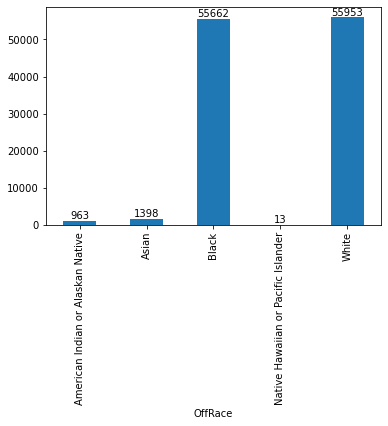

In [6]:
df=cleaned_data.groupby(["OffRace"]).size()
ax = df.plot(kind='bar')
ax.bar_label(ax.containers[0])
#print(len(y_test[(y_test["OffRace"]=="Black") | (y_test["OffRace"]=="White") ])/len(y_test))

In [7]:
import numpy as np
clf = svm.LinearSVC(dual=False)
clf.fit(x_train, y_train["OffRace"])
print("no weighted penalty for the classes")
print("done fitting")


y_true = y_test["OffRace"].tolist()
y_pred = clf.predict(x_test)

y_true = np.append(y_true,["White"])
y_pred = np.append(y_pred,["Native Hawaiian or Pacific Islander"])

print(classification_report(y_true, y_pred, target_names=list(y_train["OffRace"].unique()),zero_division=0))
print(matthews_corrcoef(y_true, y_pred))

#print(clf.score(x_test,y_test["OffRace"]))
#ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test["OffRace"],normalize='true',cmap="seismic")
#print(precision_recall_fscore_support(y_test["OffRace"],clf.predict(x_test)))

no weighted penalty for the classes
done fitting
                                     precision    recall  f1-score   support

                              Black       0.66      0.66      0.66       229
                              White       0.63      0.65      0.64       341
  American Indian or Alaskan Native       0.92      0.84      0.88     13899
                              Asian       0.00      0.00      0.00         0
Native Hawaiian or Pacific Islander       0.84      0.92      0.88     13965

                           accuracy                           0.87     28434
                          macro avg       0.61      0.61      0.61     28434
                       weighted avg       0.88      0.87      0.87     28434

0.761712661409411


In [ ]:
#best_found_weights = genetic_weight_search(30,20,svm.LinearSVC,list(cleaned_data['OffRace'].unique()),x_train,y_train["OffRace"],x_val,y_val["OffRace"])

In [8]:
#clf = svm.LinearSVC(class_weight=best_found_weights,dual=False)
clf = svm.LinearSVC(class_weight='balanced',dual=False)
clf.fit(x_train, y_train["OffRace"])
print("done fitting")

y_true = y_test["OffRace"].tolist()
y_pred = clf.predict(x_test)

y_true = np.append(y_true,["White"])
y_pred = np.append(y_pred,["Native Hawaiian or Pacific Islander"])

print(classification_report(y_true, y_pred, target_names=list(y_train["OffRace"].unique()),zero_division=0))
print(matthews_corrcoef(y_true, y_pred))

#print(clf.score(x_test,y_test["OffRace"]))
#ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test["OffRace"],normalize='true',cmap="seismic")
#print(precision_recall_fscore_support(y_test["OffRace"],clf.predict(x_test),zero_division=0))

done fitting
                                     precision    recall  f1-score   support

                              Black       0.65      0.66      0.65       229
                              White       0.54      0.64      0.58       341
  American Indian or Alaskan Native       0.92      0.83      0.87     13899
                              Asian       0.00      0.00      0.00         0
Native Hawaiian or Pacific Islander       0.84      0.92      0.88     13965

                           accuracy                           0.87     28434
                          macro avg       0.59      0.61      0.60     28434
                       weighted avg       0.88      0.87      0.87     28434

0.7512598395882455


In [9]:
clf = svm.LinearSVC(dual=False)
clf.fit(x_train, y_train["OffAge"])
print("done fitting")
#print(clf.score(x_test,y_test["OffAge"]))
#ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test["OffAge"],normalize='true',cmap="seismic")
#print(precision_recall_fscore_support(y_test["OffAge"],clf.predict(x_test)))

y_true = y_test["OffAge"].tolist()
y_pred = clf.predict(x_test)

print(classification_report(y_true, y_pred, target_names=list(y_train["OffAge"].unique())))
print(matthews_corrcoef(y_true, y_pred))

done fitting


C:\Users\PedroAntonio\Anaconda3\envs\proj\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        0-11       0.00      0.00      0.00        47
       12-14       0.33      0.07      0.11       252
       15-17       0.50      0.01      0.02      1761
       18-21       0.23      0.61      0.33      4887
       22-24       0.00      0.00      0.00      3336
       25-29       0.19      0.37      0.25      4688
       30-34       0.22      0.05      0.08      3539
       35-39       0.00      0.00      0.00      2609
       40-49       0.18      0.30      0.23      3253
       50-64       0.13      0.00      0.01      2025
         65+       0.00      0.00      0.00       647
     Unknown       0.21      0.02      0.04      1389

    accuracy                           0.21     28433
   macro avg       0.17      0.12      0.09     28433
weighted avg       0.17      0.21      0.14     28433

0.0692318528548091


C:\Users\PedroAntonio\Anaconda3\envs\proj\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PedroAntonio\Anaconda3\envs\proj\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
clf = svm.LinearSVC(class_weight='balanced',dual=False)
clf.fit(x_train, y_train["OffAge"])
print("done fitting")

y_true = y_test["OffAge"].tolist()
y_pred = clf.predict(x_test)

print(classification_report(y_true, y_pred, target_names=list(y_train["OffAge"].unique())))
print(matthews_corrcoef(y_true, y_pred))

#print(clf.score(x_test,y_test["OffAge"]))
#ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test["OffAge"],normalize='true',cmap="seismic")
#print(precision_recall_fscore_support(y_test["OffAge"],clf.predict(x_test)))

done fitting
              precision    recall  f1-score   support

        0-11       0.01      0.53      0.02        47
       12-14       0.03      0.12      0.05       252
       15-17       0.25      0.10      0.14      1761
       18-21       0.28      0.22      0.25      4887
       22-24       0.16      0.02      0.04      3336
       25-29       0.20      0.13      0.16      4688
       30-34       0.21      0.06      0.09      3539
       35-39       0.15      0.03      0.05      2609
       40-49       0.16      0.11      0.13      3253
       50-64       0.10      0.14      0.12      2025
         65+       0.07      0.57      0.12       647
     Unknown       0.12      0.45      0.18      1389

    accuracy                           0.14     28433
   macro avg       0.15      0.21      0.11     28433
weighted avg       0.19      0.14      0.13     28433

0.06594884977865352


In [12]:
clf = svm.LinearSVC(dual=False)
clf.fit(x_train, y_train['OffEthnic'])
print("done fitting")

y_true = y_test["OffEthnic"].tolist()
y_pred = clf.predict(x_test)

print(classification_report(y_true, y_pred, target_names=list(y_train["OffEthnic"].unique())))
print(matthews_corrcoef(y_true, y_pred))

#print(clf.score(x_test,y_test['OffEthnic']))
#ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test['OffEthnic'],normalize='true',cmap="seismic")
#print(precision_recall_fscore_support(y_test['OffEthnic'],clf.predict(x_test)))

done fitting
                        precision    recall  f1-score   support

Not of Hispanic origin       0.77      0.77      0.77      2724
               Unknown       0.89      0.93      0.91      8804
       Hispanic origin       0.99      0.97      0.98     16905

              accuracy                           0.94     28433
             macro avg       0.88      0.89      0.89     28433
          weighted avg       0.94      0.94      0.94     28433

0.888856434290139


In [13]:
clf = svm.LinearSVC(class_weight='balanced',dual=False)
clf.fit(x_train, y_train['OffEthnic'])
print("done fitting")

y_true = y_test["OffEthnic"].tolist()
y_pred = clf.predict(x_test)

print(classification_report(y_true, y_pred, target_names=list(y_train["OffEthnic"].unique())))
print(matthews_corrcoef(y_true, y_pred))

#print(clf.score(x_test,y_test['OffEthnic']))
#ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test['OffEthnic'],normalize='true',cmap="seismic")
#print(precision_recall_fscore_support(y_test['OffEthnic'],clf.predict(x_test)))

done fitting
                        precision    recall  f1-score   support

Not of Hispanic origin       0.77      0.77      0.77      2724
               Unknown       0.89      0.93      0.91      8804
       Hispanic origin       0.99      0.97      0.98     16905

              accuracy                           0.94     28433
             macro avg       0.88      0.89      0.89     28433
          weighted avg       0.94      0.94      0.94     28433

0.8887928069734785


In [15]:
clf = svm.LinearSVC(dual=False)
clf.fit(x_train, y_train['OffCount'])
print("done fitting")

y_true = y_test["OffCount"].tolist()
y_pred = clf.predict(x_test)

print(classification_report(y_true, y_pred, target_names=[str(s) for s in y_train["OffCount"].unique()]))
print(matthews_corrcoef(y_true, y_pred))

#print(clf.score(x_test,y_test['OffCount']))
#ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test['OffCount'],normalize='true',cmap="seismic")
#print(precision_recall_fscore_support(y_test['OffCount'],clf.predict(x_test)))

done fitting
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     23786
           1       0.00      0.00      0.00      3114
           2       1.00      0.01      0.01       949
           4       0.00      0.00      0.00       413
           3       0.00      0.00      0.00        95
           6       0.00      0.00      0.00        46
           5       0.00      0.00      0.00        16
           9       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         2

    accuracy                           0.84     28433
   macro avg       0.17      0.09      0.08     28433
weighted avg       0.73      0.84      0.76     28433

0.034587951402986074


C:\Users\PedroAntonio\Anaconda3\envs\proj\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PedroAntonio\Anaconda3\envs\proj\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PedroAntonio\Anaconda3\envs\proj\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
clf = svm.LinearSVC(class_weight='balanced',dual=False)
clf.fit(x_train, y_train['OffCount'])
print("done fitting")

y_true = y_test["OffCount"].tolist()
y_pred = clf.predict(x_test)

print(classification_report(y_true, y_pred, target_names=[str(s) for s in y_train["OffCount"].unique()]))
print(matthews_corrcoef(y_true, y_pred))

#print(clf.score(x_test,y_test['OffCount']))
#ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test['OffCount'],normalize='true',cmap="seismic")
#print(precision_recall_fscore_support(y_test['OffCount'],clf.predict(x_test)))

done fitting
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     23786
           1       0.28      0.06      0.10      3114
           2       0.12      0.02      0.04       949
           4       0.05      0.02      0.03       413
           3       0.01      0.01      0.01        95
           6       0.01      0.07      0.01        46
           5       0.00      0.06      0.00        16
           9       0.00      0.25      0.00         4
           8       0.00      0.33      0.00         3
           7       0.00      0.40      0.01         5
          10       0.00      0.00      0.00         2

    accuracy                           0.71     28433
   macro avg       0.12      0.19      0.10     28433
weighted avg       0.77      0.71      0.74     28433

0.13472596010383822


In [17]:
clf = svm.LinearSVC(dual=False)
clf.fit(x_train, y_train['Relationship'])
print("done fitting")

y_true = y_test["Relationship"].tolist()
y_pred = clf.predict(x_test)

print(classification_report(y_true, y_pred, target_names=list(y_train["Relationship"].unique())))
print(matthews_corrcoef(y_true, y_pred))

#print(clf.score(x_test,y_test['Relationship']))
#ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test['Relationship'],normalize='true',cmap="seismic")
#print(precision_recall_fscore_support(y_test['Relationship'],clf.predict(x_test)))

done fitting


C:\Users\PedroAntonio\Anaconda3\envs\proj\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PedroAntonio\Anaconda3\envs\proj\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PedroAntonio\Anaconda3\envs\proj\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

Other - known to victim       0.38      0.67      0.49      7628
               Stranger       0.00      0.00      0.00       497
           Other family       0.00      0.00      0.00       343
           Acquaintance       0.00      0.00      0.00       141
               Neighbor       0.00      0.00      0.00       142
                Brother       0.35      0.53      0.42       491
               Daughter       0.00      0.00      0.00        22
                 Father       0.00      0.00      0.00        28
             Girlfriend       0.00      0.00      0.00        45
                 Sister       0.00      0.00      0.00       113
                Unknown       0.00      0.00      0.00       301
                 Friend       0.32      0.06      0.11      1378
                 Mother       0.28      0.13      0.18      1004
             Stepfather       0.00      0.00      0.00        76
              Boyfriend 

In [18]:
clf = svm.LinearSVC(class_weight='balanced',dual=False)
clf.fit(x_train, y_train['Relationship'])
print("done fitting")

y_true = y_test["Relationship"].tolist()
y_pred = clf.predict(x_test)

print(classification_report(y_true, y_pred, target_names=list(y_train["Relationship"].unique())))
print(matthews_corrcoef(y_true, y_pred))

#print(clf.score(x_test,y_test['Relationship']))
#ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test['Relationship'],normalize='true',cmap="seismic")
#print(precision_recall_fscore_support(y_test['Relationship'],clf.predict(x_test)))

done fitting
                         precision    recall  f1-score   support

Other - known to victim       0.46      0.10      0.17      7628
               Stranger       0.08      0.10      0.09       497
           Other family       0.11      0.04      0.06       343
           Acquaintance       0.02      0.62      0.05       141
               Neighbor       0.05      0.31      0.09       142
                Brother       0.22      0.67      0.34       491
               Daughter       0.00      0.14      0.01        22
                 Father       0.00      0.07      0.01        28
             Girlfriend       0.01      0.47      0.02        45
                 Sister       0.00      0.00      0.00       113
                Unknown       0.07      0.07      0.07       301
                 Friend       0.29      0.05      0.09      1378
                 Mother       0.25      0.21      0.23      1004
             Stepfather       0.03      0.20      0.05        76
           